# Medical Provider Fraud Detection Analysis

In [2]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [69]:
train_out = pd.read_csv('data/Train_Outpatientdata.csv')
train_in = pd.read_csv('data/Train_Inpatientdata.csv')
train_ben = pd.read_csv('data/Train_Beneficiarydata.csv')
train_label = pd.read_csv('data/Train.csv')

train_out = train_out.merge(train_ben, on='BeneID', how='inner')
train_out = train_out.merge(train_label, on='Provider', how='inner')

train_in = train_in.merge(train_ben, on='BeneID', how='inner')
train_in = train_in.merge(train_label, on='Provider', how='inner')

train_out['Label'] = np.where(train_out['PotentialFraud'] == 'Yes', 1, 0)
train_out.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,0,0,30,50,Yes,1
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,1,2,0,0,1810,760,Yes,1
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,1,2,0,0,1810,760,Yes,1
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,1,2,0,0,1810,760,Yes,1
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,1,1,1,2,0,0,1810,760,Yes,1


In [15]:
train_out.shape

(517737, 53)

In [70]:
train_in['Label'] = np.where(train_in['PotentialFraud'] == 'Yes', 1, 0)
train_in.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,2,1,1,36000,3204,60,70,Yes,1
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,2009-01-20,...,1,2,2,2,19000,1068,100,20,Yes,1
2,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000,PHY334706,PHY334706,NaN,2009-10-17,...,1,1,2,2,17000,1068,1050,540,Yes,1
3,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000,PHY390614,PHY323689,PHY363291,2009-10-25,...,1,1,1,2,27000,2136,450,160,Yes,1
4,BENE24402,CLM32911,2009-01-08,2009-01-12,PRV55912,3000,PHY380413,PHY432598,NaN,2009-01-08,...,1,2,2,2,3000,1068,8900,740,Yes,1


In [85]:
train_out['Outpatient'] = 1
train_in['Outpatient'] = 0
full_train = train_out.append(train_in)
full_train.head()

/tmp/ipykernel_1967/1069288541.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_train = train_out.append(train_in)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,Label,Outpatient,AdmissionDt,DischargeDt,DiagnosisGroupCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0,0,30,50,Yes,1,1,NaN,NaN,NaN
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,0,0,1810,760,Yes,1,1,NaN,NaN,NaN


# EDA

# EDA

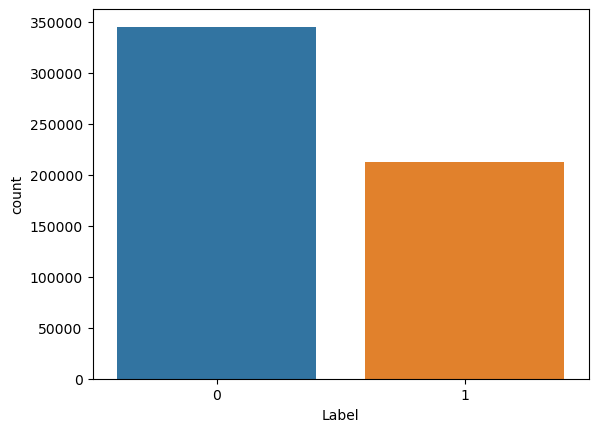

In [18]:
sns.countplot(data=full_train, x='Label');

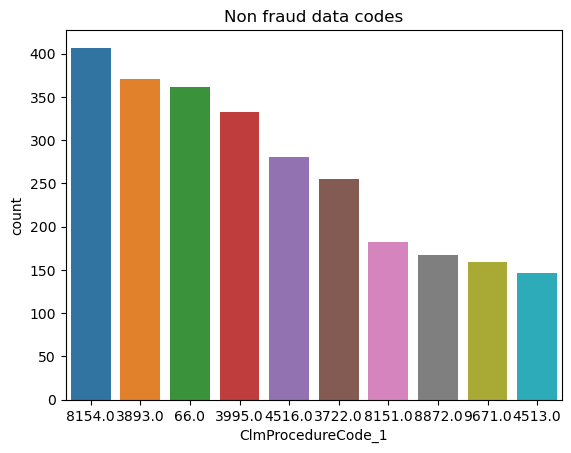

In [19]:
train_nofraud = full_train[full_train['Label']==0]
train_fraud = full_train[full_train['Label']==1]
sns.countplot(x='ClmProcedureCode_1', data=train_nofraud, order=train_nofraud['ClmProcedureCode_1'].value_counts().sort_values(ascending=False).index[1:11])

plt.title('Non fraud data codes');

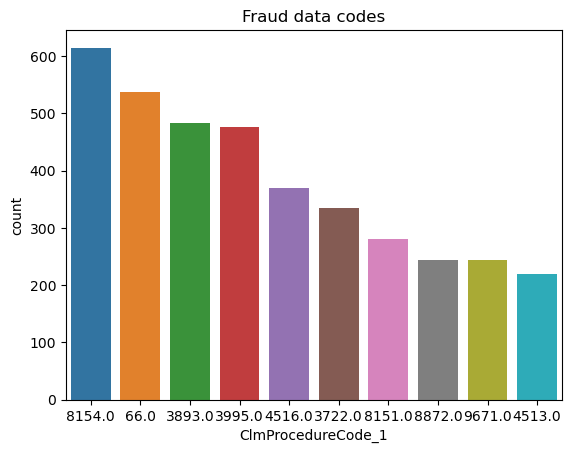

In [20]:
sns.countplot(x='ClmProcedureCode_1', data=train_fraud, order=train_fraud['ClmProcedureCode_1'].value_counts().sort_values(ascending=False).index[1:11])
plt.title('Fraud data codes');

In [21]:
important_clm_codes = np.unique(np.append(train_fraud['ClmProcedureCode_1'].value_counts().index[1:25], train_nofraud['ClmProcedureCode_1'].value_counts().index[1:25]))

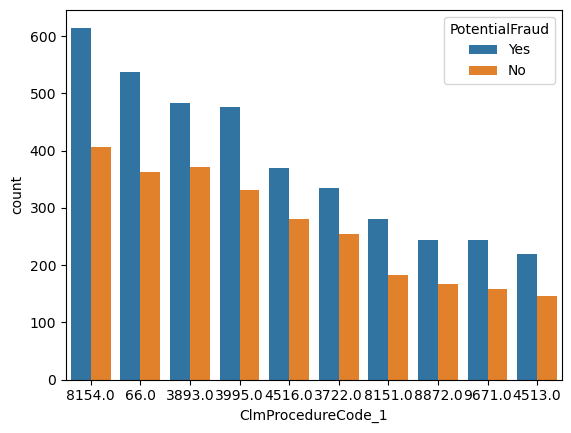

In [22]:
sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=full_train, order=full_train['ClmProcedureCode_1'].value_counts().index[1:11]);
#9904 - transfusion of packed cells
#4516 - EGD

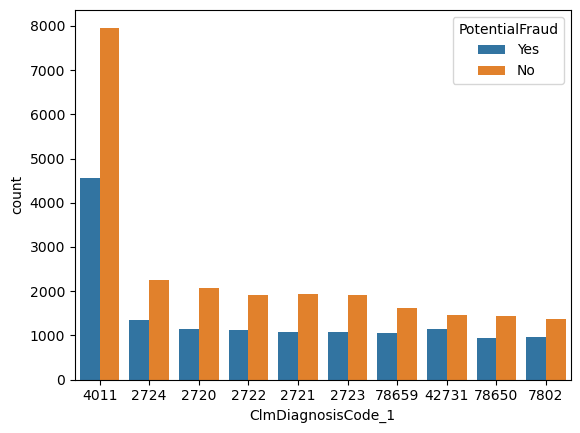

In [23]:
sns.countplot(x='ClmDiagnosisCode_1',hue='PotentialFraud',data=full_train, order=full_train['ClmDiagnosisCode_1'].value_counts().index[1:11]);

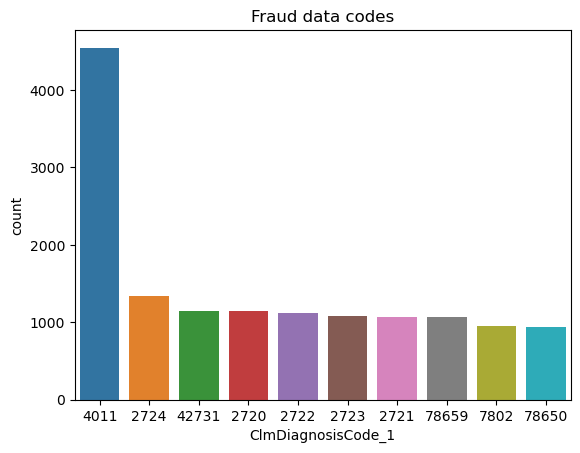

In [24]:
sns.countplot(x='ClmDiagnosisCode_1', data=train_fraud, order=train_fraud['ClmDiagnosisCode_1'].value_counts().sort_values(ascending=False).index[1:11]);
plt.title('Fraud data codes');

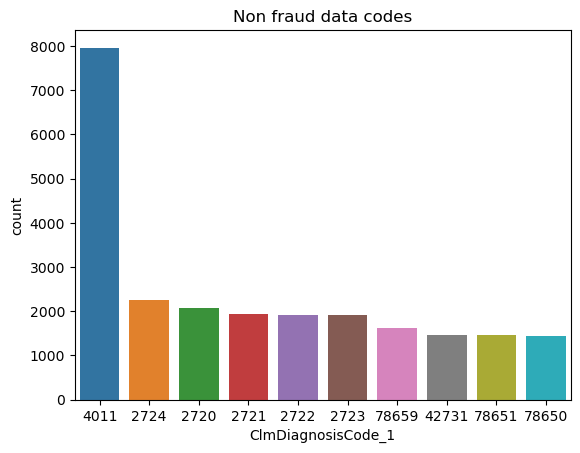

In [25]:
sns.countplot(x='ClmDiagnosisCode_1', data=train_nofraud, order=train_nofraud['ClmDiagnosisCode_1'].value_counts().sort_values(ascending=False).index[1:11]);
plt.title('Non fraud data codes');

In [26]:
important_diag_codes = np.unique(np.append(train_fraud['ClmDiagnosisCode_1'].value_counts().index[1:25], train_nofraud['ClmDiagnosisCode_1'].value_counts().index[1:25]))

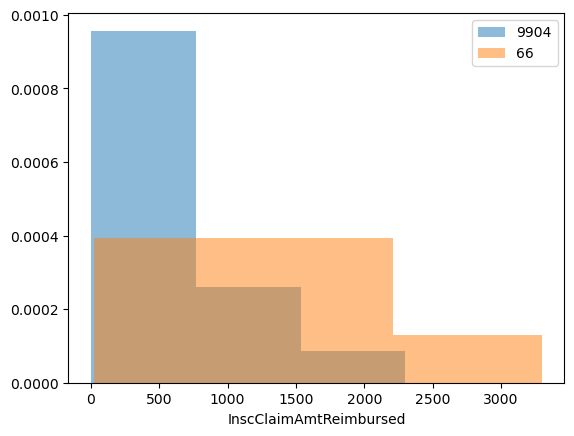

In [27]:
# examine data for 9904 and 66, compare those with relatively higher potential fraud and vice versa
plt.hist(train_out[train_out['ClmProcedureCode_1']==9904]['InscClaimAmtReimbursed'], bins = 3, alpha=0.5, label='9904', density=True)
plt.hist(train_out[train_out['ClmProcedureCode_1']==66]['InscClaimAmtReimbursed'], bins = 3, alpha=0.5, label='66', density=True)
plt.legend();
plt.xlabel('InscClaimAmtReimbursed');

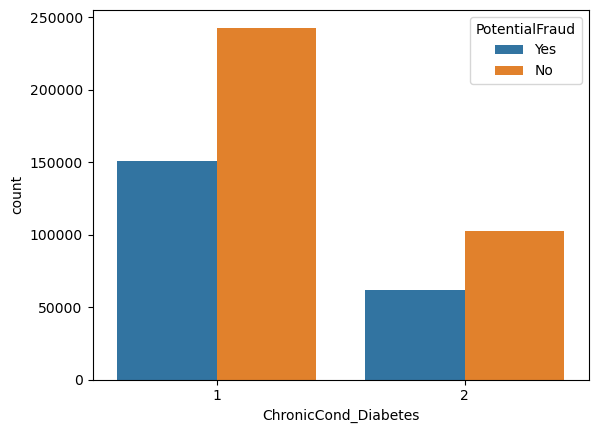

In [28]:
sns.countplot(x='ChronicCond_Diabetes',hue='PotentialFraud',data=full_train);

In [29]:
# examine other providers who give the same diagnoses codes and PRV51459 (diag 4019)
out_4019 = full_train.loc[full_train['ClmDiagnosisCode_1'] == '4019']
out_4019['Provider'].value_counts()[:5]

PRV51459    220
PRV53797    139
PRV51574    120
PRV55215     89
PRV54895     86
Name: Provider, dtype: int64

In [30]:
print(train_label.loc[train_label['Provider']=='PRV53797'])
print(train_label.loc[train_label['Provider']=='PRV51574'])
print(train_label.loc[train_label['Provider']=='PRV55215'])


      Provider PotentialFraud
2250  PRV53797            Yes
     Provider PotentialFraud
455  PRV51574            Yes
      Provider PotentialFraud
3363  PRV55215            Yes


# Preprocessing

In [31]:
full_train.isnull().sum()

BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                 534901
ClmProcedureCode_2                 552721
ClmProcedureCode_3                 557242
ClmProcedureCode_4                 558093
ClmProcedureCode_5                

In [86]:
full_train['AdmissionDt'] = pd.to_datetime(full_train['AdmissionDt'])  
full_train['DischargeDt'] = pd.to_datetime(full_train['DischargeDt'])  
full_train['DOB'] = pd.to_datetime(full_train['DOB'])  
full_train['DOD'] = pd.to_datetime(full_train['DOD'])  

full_train['StayDuration'] = (full_train['DischargeDt'] - full_train['AdmissionDt']).dt.days
full_train['StayDuration'].fillna(0.0)

today = datetime(2022, 1, 1)
full_train['DOD'].fillna(today)
full_train['Age'] = ((today - full_train['DOB']).dt.days)/365

full_train = full_train.join(pd.get_dummies(full_train['Race'], drop_first=True))
full_train = full_train.rename(columns={2: "Race1", 3: "Race2", 5: "Race3"})

full_train = full_train.fillna(0)
full_train = full_train.drop_duplicates()

In [87]:
# encode significant codes
for code in important_clm_codes: 
    full_train['Clm'+str(code)] = 0
    full_train.loc[full_train['ClmProcedureCode_1'].astype(float) == code, 'Clm'+str(code)] = 1

for code in important_diag_codes:
    full_train['Diag'+str(code)] = 0
    full_train.loc[full_train['ClmDiagnosisCode_1'] == code, 'Diag'+str(code)] = 1

# More EDA

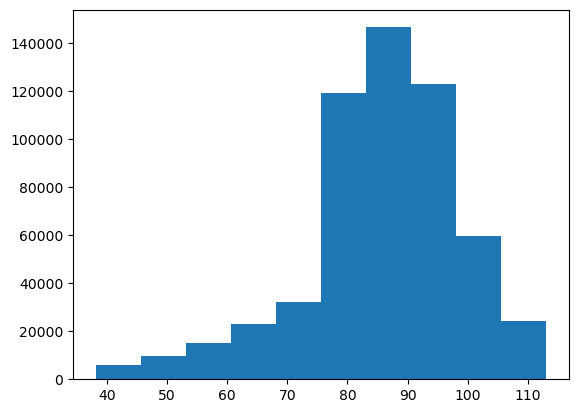

In [35]:
plt.hist(full_train['Age'], bins=10);

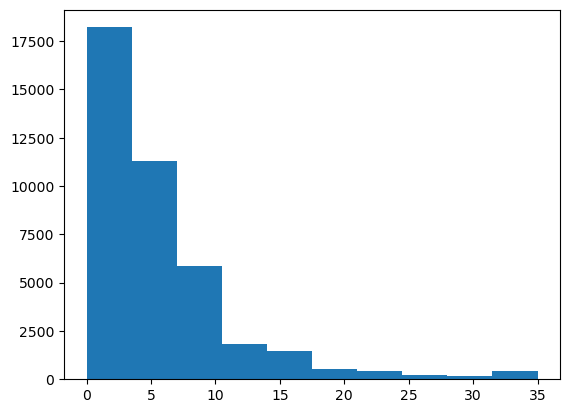

In [36]:
plt.hist(full_train[full_train['Outpatient']==0]['StayDuration'], bins=10);

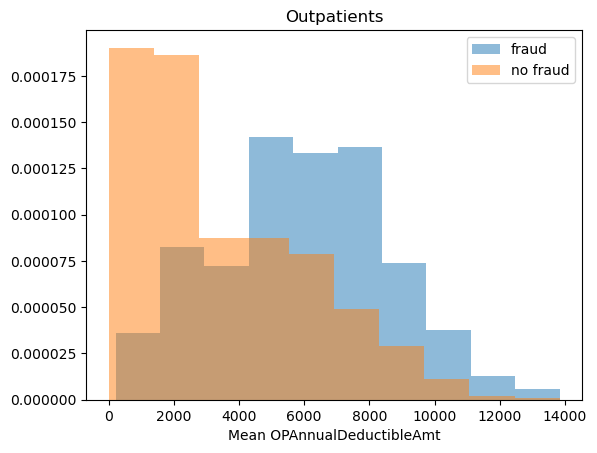

In [37]:
out_data = full_train[full_train['Outpatient']==1]
in_data = full_train[full_train['Outpatient']==0]

plt.hist(train_fraud.groupby('Provider').agg('max', numeric_only=True)['OPAnnualDeductibleAmt'], density=True, bins=10, label='fraud', alpha=0.5);
plt.hist(train_nofraud.groupby('Provider').agg('max', numeric_only=True)['OPAnnualDeductibleAmt'], density=True, bins=10, label='no fraud', alpha=0.5);
plt.legend();
plt.xlabel('Mean OPAnnualDeductibleAmt');
plt.title('Outpatients');

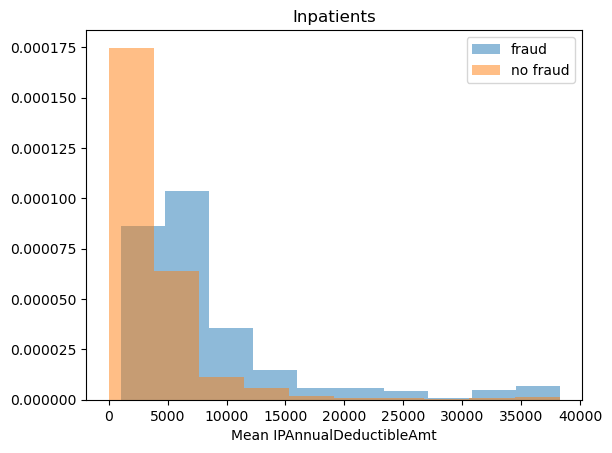

In [38]:
plt.hist(train_fraud.groupby('Provider').agg('max', numeric_only=True)['IPAnnualDeductibleAmt'], density=True, bins=10, label='fraud', alpha=0.5);
plt.hist(train_nofraud.groupby('Provider').agg('max', numeric_only=True)['IPAnnualDeductibleAmt'], density=True, bins=10, label='no fraud',  alpha=0.5);
plt.legend();
plt.xlabel('Mean IPAnnualDeductibleAmt');
plt.title('Inpatients');

# Models

In [88]:
full_train.columns

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1',
       ...
       'Diag7802', 'Diag78079', 'Diag7850', 'Diag78650', 'Diag78651',
       'Diag78659', 'Diag79029', 'Diag7915', 'DiagV4585', 'DiagV5789'],
      dtype='object', length=120)

In [89]:
full_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Diag7802,Diag78079,Diag7850,Diag78650,Diag78651,Diag78659,Diag79029,Diag7915,DiagV4585,DiagV5789
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,0,0,78943,...,0,0,0,0,0,0,0,0,0,0
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,0,0,1970,...,0,0,0,0,0,0,0,0,0,0
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,0,0,71988,...,0,0,0,0,0,0,0,0,0,0
1,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000,PHY349293,PHY370861,PHY363291,4240,...,0,0,0,0,0,0,0,0,0,0
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,0,0,82382,...,0,0,0,0,0,0,0,0,0,0


In [90]:
full_train.to_csv('data/full_train.csv')

In [3]:
full_train = pd.read_csv('data/full_train.csv')

/tmp/ipykernel_35511/1231026081.py:1: DtypeWarning: Columns (55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  full_train = pd.read_csv('data/full_train.csv')


In [4]:
full_train.shape

(581389, 121)

In [5]:
# simple SLR 
columns = ['InscClaimAmtReimbursed','Gender', 'Race',
       'RenalDiseaseIndicator', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt',
       'Outpatient', 'StayDuration', 'Age', 'Race1', 'Race2', 'Race3',
        'Clm66.0', 'Clm309.0', 'Clm387.0', 'Clm3491.0', 'Clm3722.0',
       'Clm3772.0', 'Clm3812.0', 'Clm3893.0', 'Clm3950.0', 'Clm3995.0',
       'Clm4513.0', 'Clm4516.0', 'Clm4523.0', 'Clm4525.0', 'Clm5123.0',
       'Clm7935.0', 'Clm8108.0', 'Clm8151.0', 'Clm8152.0', 'Clm8154.0',
       'Clm8622.0', 'Clm8872.0', 'Clm9339.0', 'Clm9390.0', 'Clm9671.0',
       'Clm9672.0', 'Clm9921.0', 'Diag185', 'Diag25000', 'Diag2720',
       'Diag2721', 'Diag2722', 'Diag2723', 'Diag2724', 'Diag4011', 'Diag41401',
       'Diag4271', 'Diag42731', 'Diag42732', 'Diag42761', 'Diag42769',
       'Diag42781', 'Diag42789', 'Diag4279', 'Diag4280', 'Diag486',
       'Diag49121', 'Diag5990', 'Diag7802', 'Diag78079', 'Diag7850',
       'Diag78650', 'Diag78651', 'Diag78659', 'Diag79029', 'Diag7915',
       'DiagV4585', 'DiagV5789']
full_train[columns]['RenalDiseaseIndicator']

0         0
1         0
2         0
3         0
4         0
         ..
581384    0
581385    0
581386    Y
581387    0
581388    0
Name: RenalDiseaseIndicator, Length: 581389, dtype: object

In [6]:
full_train.loc[ full_train['RenalDiseaseIndicator'] == 'Y', 'RenalDiseaseIndicator'] = 1
full_train.loc[ full_train['RenalDiseaseIndicator'] == '0', 'RenalDiseaseIndicator'] = 1
full_train['RenalDiseaseIndicator'] = pd.to_numeric(full_train['RenalDiseaseIndicator'])
X = full_train[columns]
y = full_train['Label']
print(X.shape)
print(y.shape)

(581389, 85)
(581389,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
logreg_preds = logreg.predict(X_train)

logreg.score(X_train, y_train)

0.6134854825045568

In [45]:
precision_recall_fscore_support(y_train, logreg_preds, average='macro')

(0.6016074160694629, 0.5093990012803659, 0.4139757756230674, None)

In [48]:
# XGB 
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.6488672490180507


(0.6585821948053456, 0.5533511296296928, 0.5099621322017781, None)

In [49]:
xgb.feature_importances_

array([0.00347738, 0.00634662, 0.01724059, 0.        , 0.00651361,
       0.00866806, 0.00637579, 0.0075376 , 0.00765481, 0.00639473,
       0.00620897, 0.00816486, 0.00871588, 0.00767193, 0.00735635,
       0.00623005, 0.00818267, 0.00846213, 0.00751899, 0.00971416,
       0.00970701, 0.6272076 , 0.00487492, 0.00847191, 0.        ,
       0.00321806, 0.00151985, 0.00487958, 0.00426901, 0.00091045,
       0.        , 0.00349822, 0.00296866, 0.00505195, 0.        ,
       0.00540421, 0.00638128, 0.        , 0.        , 0.00824407,
       0.        , 0.0077261 , 0.00394121, 0.00396182, 0.        ,
       0.00198528, 0.00562818, 0.00337458, 0.        , 0.00286923,
       0.00489939, 0.00264213, 0.00261498, 0.00246245, 0.00370426,
       0.00549078, 0.00167829, 0.00498071, 0.        , 0.        ,
       0.00134031, 0.00720327, 0.00686051, 0.00131658, 0.00424709,
       0.00704547, 0.00261499, 0.00666296, 0.        , 0.00361298,
       0.00565393, 0.00369794, 0.0017629 , 0.01098128, 0.00289

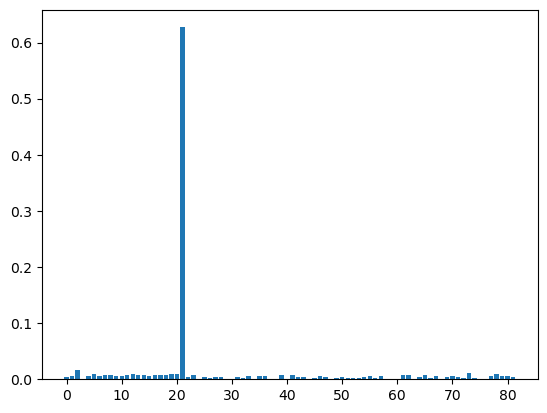

In [52]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()


In [54]:
columns[np.argmax(xgb.feature_importances_)]

'Outpatient'

In [8]:
outpatient_data = full_train[full_train['Outpatient']==1]

X = outpatient_data[columns]
y = outpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# XGB 
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.6541331122690668


(0.7152859873386093, 0.5417585440386207, 0.47919435638079766, None)

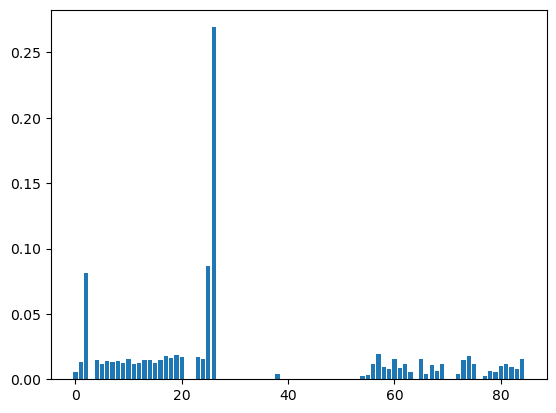

In [9]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [10]:
columns[np.argmax(xgb.feature_importances_)]

'Race3'

In [61]:
inpatient_data = full_train[full_train['Outpatient']==0]

X = inpatient_data[columns]
y = inpatient_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# XGB 
xgb = XGBClassifier().fit(X_train, y_train)
xgb_preds = xgb.predict(X_train)
accuracy = accuracy_score(y_train, xgb_preds)

print(accuracy)
precision_recall_fscore_support(y_train, xgb_preds, average='macro')

0.7368440461702991


(0.7853693800524291, 0.6961569571007373, 0.6959677812147291, None)

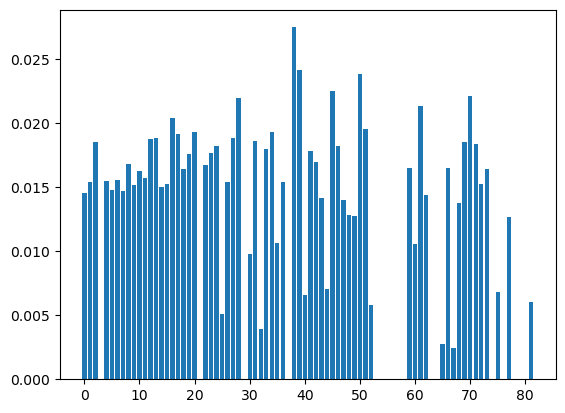

In [62]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [63]:
columns[np.argmax(xgb.feature_importances_)]

'Clm5123.0'

In [18]:
inpatient_data[(inpatient_data['Clm5123.0']==1) & (inpatient_data['Label']==1)]['Provider'].value_counts()

PRV56416    7
PRV51501    6
PRV56560    5
PRV55018    4
PRV52903    4
           ..
PRV55049    1
PRV52843    1
PRV53786    1
PRV53269    1
PRV53397    1
Name: Provider, Length: 115, dtype: int64

In [19]:
inpatient_data[(inpatient_data['Clm5123.0']==1) & (inpatient_data['Label']==0)]['Provider'].value_counts()

PRV52889    4
PRV55978    3
PRV54324    3
PRV52611    2
PRV56456    2
           ..
PRV56478    1
PRV54971    1
PRV52881    1
PRV53932    1
PRV52850    1
Name: Provider, Length: 120, dtype: int64